In [185]:
import os
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
import pandas as pd
from torch.distributions import constraints
from matplotlib import pyplot
from matplotlib.patches import Ellipse
import plotly.express as px
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('0.4.1')
pyro.enable_validation(True)
pd.set_option('display.max_columns', None)
pyplot.style.use('ggplot')

Write down all the features and their implication here:

In [186]:
FILE_DIR = "../"
tmdb_path = os.path.join(FILE_DIR,"data","the-movies-dataset")
movies_metadata_dir = os.path.join(tmdb_path, "movies_metadata_processed.csv")
movies_metadata = pd.read_csv(movies_metadata_dir)
movies_metadata.head()

,belongs_to_collection,budget,id,original_title,popularity,revenue,runtime,vote_average,vote_count,revenue_mil,budget_mil,drama,comedy,thriller,action,romance,adventure,family,release_2010s,release_2000s,release_1990s,release_1980s_below,overview_vader,tagline_vader
0,0,30000000,862,Toy Story,21.946943,373554033.0,81.0,7.7,5415.0,373.554033,30.0,0,1,0,0,0,0,1,0,0,1,0,0.1280,0.0000
1,1,65000000,8844,Jumanji,17.015539,262797249.0,104.0,6.9,2413.0,262.797249,65.0,0,0,0,0,0,1,1,0,0,1,0,-0.4588,0.5411
2,1,16000000,31357,Waiting to Exhale,3.859495,81452156.0,127.0,6.1,34.0,81.452156,16.0,1,1,0,0,1,0,0,0,0,1,0,0.8860,0.5812
3,1,60000000,949,Heat,17.924927,187436818.0,170.0,7.7,1886.0,187.436818,60.0,1,0,1,1,0,0,0,0,0,1,0,-0.8750,-0.5423
4,1,35000000,9091,Sudden Death,5.231580,64350171.0,106.0,5.5,174.0,64.350171,35.0,0,0,1,1,0,1,0,0,0,1,0,0.5106,-0.5267


In [242]:
def normalize(np_arr):
    return (np_arr - np.mean(np_arr)) / np.std(np_arr)
movies_metadata['revenue'] = normalize(movies_metadata['revenue'])
movies_metadata['budget'] = normalize(movies_metadata['budget'])

px.scatter(movies_metadata, x="revenue", y="budget", hover_name="original_title", color = "family")

In [255]:
# Stack features
features = np.stack((movies_metadata['revenue'], movies_metadata['budget']), axis=1)

# Must be in float32
data = torch.tensor(features, dtype=torch.float32 )

# Take subset of data
data = data[:500]

For $N$ data points, the likelihood is:
\begin{equation}
    p(x_n | \pi, \mu, \sigma^2) = \sum_{k=1}^{K} \pi_k N(x_n | \mu_k, \sigma_k^2)
\end{equation}

Define prior $\pi \in [0,1]$ such that $\sum_{k=1}^{K} \pi_k = 1$
\begin{equation}
    p(\pi) = Dir(\pi | \alpha \mathbb{1}_K)
\end{equation}

for fixed $\alpha = 1$. Prior for each $\mu_k \in \mathbb{R}^D$
\begin{equation}
    p(\mu_k) = Normal(\mu_k | 0, I)
\end{equation}

Prior for each component $\sigma_k^2 \in \mathbb{R}^D$ to be
\begin{equation}
    p(\sigma_k^2) = InvGamma(\sigma_k^2 | a, b)
\end{equation}

In [304]:
# Number of clusters
K = 5

# Number of dimensions
d = len(features[0])

def model(data):
    """
    weights: pi
    locs: mean
    scale: variance
    """
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(K)))
    with pyro.plate('component', K):
        locs = pyro.sample('locs', dist.MultivariateNormal(torch.zeros(d), 1*torch.eye(d)))
        scale = pyro.sample('scale', dist.InverseGamma(1, 1))
    
    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        
        #print(scale)
        scale_ = scale[assignment].repeat(d, d, 1).transpose(2, 0)
        scale_ *= torch.eye(d).repeat(len(assignment), 1, 1)
        
        #pyro.sample('obs', dist.MultivariateNormal(locs[assignment], scale_), obs=data)
        pyro.sample('obs', dist.MultivariateNormal(locs[assignment], scale_[assignment]), obs=data)
        
global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']))

In [305]:
optim = pyro.optim.Adam({'lr': 0.1})
elbo = TraceEnum_ELBO()
svi = SVI(model, global_guide, optim, loss=elbo)

In [306]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    loss = svi.loss(model, global_guide, data)
    return loss

# Randomize 100 inits, choose the best
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, init loss = {}'.format(seed, loss))

tensor([1.0038, 1.5504])


IndexError: index 4 is out of bounds for dimension 0 with size 2

In [292]:
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(1000):
    loss = svi.step(data)
    losses.append(loss)

/anaconda3/lib/python3.6/site-packages/pyro/util.py:183: UserWarning:

Found vars in model but not guide: {'assignment'}

/anaconda3/lib/python3.6/site-packages/pyro/infer/traceenum_elbo.py:282: UserWarning:

TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.



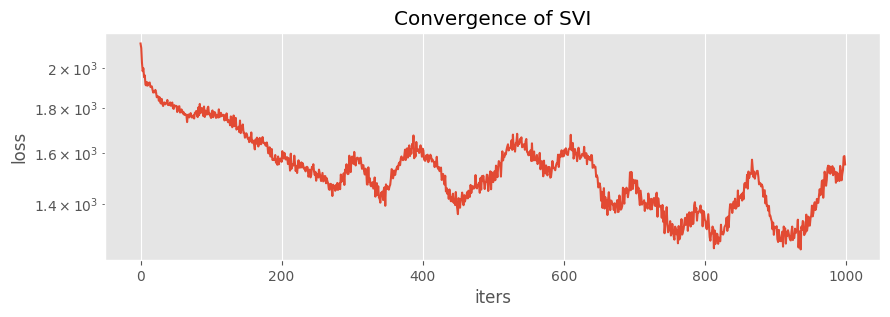

In [293]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

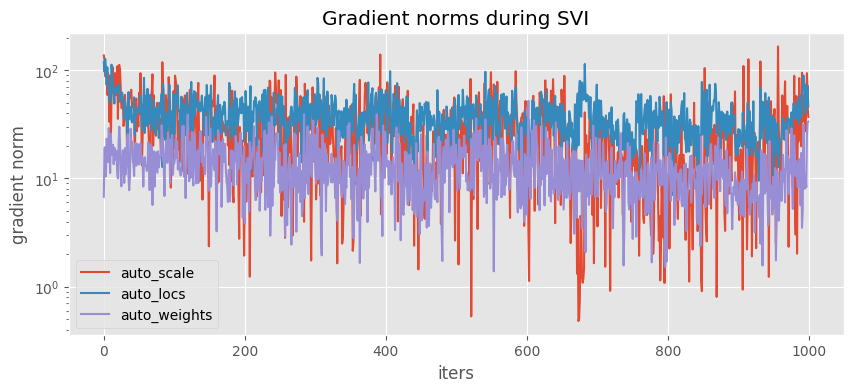

In [294]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [295]:
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scale = {}'.format(scale.data.numpy()))

weights = [0.04101998 0.05996085 0.00589641 0.6542983  0.23882443]
locs = [[ 0.14193645 -0.25217566]
 [ 0.02303905 -0.2059123 ]
 [-0.12245367 -0.09355297]
 [-0.048241   -0.24239978]
 [-0.01227236 -0.12417763]]
scale = [0.5253033  0.47406125 0.5022535  0.59298706 0.5838917 ]


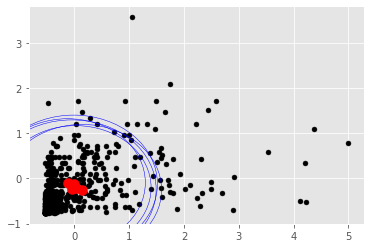

In [296]:
# Plot 2D GMMs
def plot(data, mus=None, sigmas=None, colors='black', figname='fig.png'):
    # Create figure
    fig = pyplot.figure()

    # Plot data
    x = data[:, 0]
    y = data[:, 1]
    pyplot.scatter(x, y, 24, c=colors)

    # Plot cluster centers
    if mus is not None:
        x = [float(m[0]) for m in mus]
        y = [float(m[1]) for m in mus]
        pyplot.scatter(x, y, 99, c='red')

    # Plot ellipses for each cluster
    if sigmas is not None:
        for sig_ix in range(K):
            ax = fig.gca()
            
            # Turn to covariance matrix if variance only
            cov = (torch.eye(d) * sigmas[sig_ix]).detach().numpy()

            lam, v = np.linalg.eig(cov)
            lam = np.sqrt(lam)
            ell = Ellipse(xy=(x[sig_ix], y[sig_ix]),
                          width=lam[0]*4, height=lam[1]*4,
                          angle=np.rad2deg(np.arccos(v[0, 0])),
                          color='blue')
            ell.set_facecolor('none')
            ax.add_artist(ell)
plot(data, locs, scale)

In [297]:
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
pyro.set_rng_seed(2)
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=250, warmup_steps=50)
mcmc.run(data)
posterior_samples = mcmc.get_samples()

Warmup:   0%|          | 0/300 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (10) must match the size of tensor b (2) at non-singleton dimension 1
  Trace Shapes:          
   Param Sites:          
  Sample Sites:          
   weights dist       | 5
          value       | 5
 component dist       |  
          value     5 |  
      locs dist     5 | 2
          value     5 | 2
     scale dist     5 |  
          value     5 |  
      data dist       |  
          value   500 |  
assignment dist   500 |  
          value 5   1 |  